In [116]:
%%capture

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchtext.vocab import build_vocab_from_iterator
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score_fn
import matplotlib.pyplot as plt
import random
import re
from collections import Counter
from tqdm import tqdm


import pickle
import numpy as np
import pandas as pd
import time
import os
import sys
import spacy
import ast

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [101]:

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


In [102]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [104]:
# data 다운
train_path = 'Cooking_Dataset/test.csv'
dev_path = 'Cooking_Dataset/dev.csv'
test_path = 'Cooking_Dataset/test.csv'

train_download = "https://drive.google.com/file/d/1uZdYjvllt0dSdKKtrCgKHUk-APKdmeNU/view?usp=drive_link"
dev_download ="https://drive.google.com/file/d/1SAMbkdtjGBYgojqobiwe7ZmnEq7SiGsF/view?usp=drive_link"
test_download = "https://drive.google.com/file/d/1v6Rr2et_4WA5mRwwlRxtLhn38pbmr9Yr/view?usp=drive_link"

if not os.path.exists('Cooking_Dataset'):
    os.makedirs('Cooking_Dataset')
    print("Downloading Dataset")
    gdown.download(train_download, train_path, quiet=False)
    gdown.download(dev_download, dev_path, quiet=False)
    gdown.download(test_download, test_path, quiet=False)


train_df = pd.read_csv(train_path,  encoding="ISO-8859-1")
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

# 데이터 확인
print(f"Train data size: {len(train_df)}")
print(f"Dev data size: {len(dev_df)}")
print(f"Test data size: {len(test_df)}")
print("\nTrain data sample:")
print(train_df.head())
#No-Bake Nut Cookies
# ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]
# ["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]

Train data size: 1081
Dev data size: 1065
Test data size: 1081

Train data sample:
                     Title                                        Ingredients  \
0     "Too Good" Fruit Dip  ["1 (8 oz.) pkg. cream cheese", "1 small jar M...   
1              Sloppy Joes  ["1 lb. ground beef", "1/2 c. onions, cut up (...   
2    Lemon Congealed Salad  ["1 large box lemon jello", "1 large can crush...   
3  Parmesan Vegetable Toss  ["2 c. mayonnaise", "1/2 c. grated Parmesan ch...   
4      Holiday Fruit Drops  ["3 1/2 c. flour (sifted all-purpose)", "1 tsp...   

                                              Recipe  
0  ["Whip cream cheese with mixer until smooth.",...  
1  ["Combine all ingredients.", "Cook 30 minutes....  
2  ["Drain juice from pineapple and save.", "Prep...  
3  ["In a large bowl, combine mayonnaise, Parmesa...  
4  ["Sift together into bowl and reserve flour, s...  


In [105]:
spacy_en = spacy.load('en_core_web_sm')

def tokenizer_ingredient(text, remove_stopwords=True, lemmatize=True):
    text_list = ast.literal_eval(text)
    tokens = []
    unit_keywords = {'c', 'tbsp', 'tsp', 'oz', 'lb', 'pkg', 'inch'}

    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):

        for item in text_list:
            doc = spacy_en(item.lower())

            for token in doc:
                # 특수문자, 쉼표 제거
                if token.is_punct:
                    continue

                # 숫자 제거
                if token.like_num:
                    continue

                # 단위 제거 (c., tbsp., tsp., oz., lb.)
                if token.text.lower().strip('.') in unit_keywords:
                    continue

                # 불용어 제거 (선택)
                if remove_stopwords and token.is_stop:
                    continue

                # 레마타이징 또는 원형 유지
                if lemmatize:
                    tokens.append(token.lemma_)
                else:
                    tokens.append(token.text)
    return tokens

def tokenizer_recipe(text, lemmatize=True):
    text_list = ast.literal_eval(text)
    tokens = []

    with spacy_en.select_pipes(disable=["tagger", "parser", "ner"]):
        for item in text_list:
            doc = spacy_en(item.lower())
            for token in doc:
                # 특수문자 제외 (예: . , ( ) 등 → 필요하면 살려도 됨)
                if not token.is_alpha and not token.like_num:
                    continue
                # 숫자 포함
                if token.like_num:
                    tokens.append(token.text)
                    continue
                # 단위 포함
                if token.text.lower() in ['c.', 'tbsp.', 'tsp.', 'oz.', 'lb.', 'g', 'ml', 'kg']:
                    tokens.append(token.text.lower())
                    continue
                # 일반 단어
                if lemmatize:
                    tokens.append(token.lemma_)
                else:
                    tokens.append(token.text)
    return tokens



In [106]:
ing = train_df.iloc[1,2]
print(ing)
print(tokenizer_recipe(ing))

["Combine all ingredients.", "Cook 30 minutes.", "Serve on warm buns."]
['combine', 'all', 'ingredients', 'cook', '30', 'minutes', 'serve', 'on', 'warm', 'buns']


/Users/jeeeunkim/Desktop/FIT5217_NLP/NLP/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [107]:
def build_vocab(token_lists, min_freq=2):
    # vocab 생성: 자주 등장하는 단어만 포함 + 특수 토큰 정의
    vocab = build_vocab_from_iterator(
        token_lists,  # 토큰 리스트들을 직접 반복
        min_freq=min_freq,  # 최소 등장 빈도
        specials=['<pad>', '<sos>', '<eos>', '<unk>']  # 특수 토큰 추가
    )
    vocab.set_default_index(vocab['<unk>'])  # 없는 단어는 <unk>로 처리
    return vocab

In [108]:
# 캐시된 파일명
ingredient_cache_path = "tokens/ingredient_tokens.pkl"
recipe_cache_path = "tokens/recipe_tokens.pkl"

ingredient_cache_download = "https://drive.google.com/file/d/1QLlXnSKMNtI9N2VFFT4zdSokoTQ-jo6j/view?usp=drive_link"
recipe_cache_dowload = "https://drive.google.com/file/d/1pc_hcD9OCUaggWBhMd_EFiyPdo4tplA6/view?usp=drive_link"


if not os.path.exists('tokens'):
    os.makedirs('tokens')
    print("Downloading caches")
    gdown.download(ingredient_cache_download, ingredient_cache_path, quiet=False)
    gdown.download(recipe_cache_dowload, recipe_cache_path, quiet=False)
   

# 캐시가 있다면 불러오기, 없으면 토큰화해서 저장
try:
    with open(ingredient_cache_path, "rb") as f:
        ingredient_token_lists = pickle.load(f)
    with open(recipe_cache_path, "rb") as f:
        recipe_token_lists = pickle.load(f)
    print("Successfully loaded the cached token list!")
except FileNotFoundError:
    print("No cache found → Starting tokenization...")
    ingredient_token_lists = [tokenizer_ingredient(text) for text in tqdm(train_df['Ingredients'], desc="Tokenizing ingredients")]
    recipe_token_lists = [tokenizer_recipe(text) for text in tqdm(train_df['Recipe'], desc="Tokenizing recipes")]
    # 저장
    with open(ingredient_cache_path, "wb") as f:
        pickle.dump(ingredient_token_lists, f)
    with open(recipe_cache_path, "wb") as f:
        pickle.dump(recipe_token_lists, f)
    print("Saved token list!")



# Vocab 생성 (2번 이상 등장한 단어만 포함)
ingredient_vocab = build_vocab(ingredient_token_lists)
recipe_vocab = build_vocab(recipe_token_lists)

# 확인
print("Ingredient vocab size:", len(ingredient_vocab))
print("Recipe vocab size:", len(recipe_vocab))

# 예시로 일부 단어 출력
print("Sample ingredient tokens:", list(enumerate(ingredient_vocab.get_itos()))[:10])
print("Sample recipe tokens:", list(enumerate(recipe_vocab.get_itos()))[:10])



Exception ignored in: <function tqdm.__del__ at 0x12a356f80>
Traceback (most recent call last):
  File "/Users/jeeeunkim/Desktop/FIT5217_NLP/NLP/.venv/lib/python3.10/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/jeeeunkim/Desktop/FIT5217_NLP/NLP/.venv/lib/python3.10/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


Successfully loaded the cached token list!
Ingredient vocab size: 5465
Recipe vocab size: 8471
Sample ingredient tokens: [(0, '<pad>'), (1, '<sos>'), (2, '<eos>'), (3, '<unk>'), (4, 'chopped'), (5, 'sugar'), (6, 'salt'), (7, 'pepper'), (8, 'cream'), (9, 'cheese')]
Sample recipe tokens: [(0, '<pad>'), (1, '<sos>'), (2, '<eos>'), (3, '<unk>'), (4, 'and'), (5, 'in'), (6, 'add'), (7, 'to'), (8, 'until'), (9, 'with')]


In [109]:
class CustomDataset(Dataset):
    def __init__(self,df,ingredient_vocab,recipe_vocab):
        self.df = df
        self.ingredient_vocab = ingredient_vocab
        self.recipe_vocab = recipe_vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 전처리된 텍스트 토큰화
        ingredient_tokens = tokenizer_ingredient(self.df.iloc[idx]["Ingredients"])
        recipe_tokens = tokenizer_recipe(self.df.iloc[idx]["Recipe"])

        # 인덱스로 변환
        ingredient_ids = [self.ingredient_vocab[token] for token in ingredient_tokens]
        recipe_ids = [self.recipe_vocab['<sos>']] + [self.recipe_vocab[token] for token in recipe_tokens ]+[self.recipe_vocab['<eos>']]

        # 텐서로
        return torch.tensor(ingredient_ids), torch.tensor(recipe_ids)

In [11]:
def collate_fn(batch):
    ingredients, recipes = zip(*batch)
    ingredients_padded = pad_sequence(ingredients, batch_first=True, padding_value=ingredient_vocab['<pad>'])
    recipes_padded = pad_sequence(recipes, batch_first=True, padding_value=recipe_vocab['<pad>'])
    return ingredients_padded.to(DEVICE), recipes_padded.to(DEVICE)


Ingredients batch shape: torch.Size([64, 36])
Recipes batch shape: torch.Size([64, 85])


In [ ]:
class Encoder_GRU(nn.Module):
    def __init__(self, ingredient_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio):
        super().__init__()
        # 임베딩
        self.embedding = nn.Embedding(ingredient_vocab_size,embedding_dim)

        # GRU 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          n_layers,
                          dropout=dropout_ratio if n_layers>1 else 0,
                          batch_first=True)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src):
        # src : [batch_size, src_len]

        # 임베딩
        embedded = self.dropout(self.embedding(src))
        # embedded : [batch_size, src_len, hidden_dim]

        # gru 통과
        outputs, hidden = self.gru(embedded) # h0를 따로 주지 않으면, 디폴트로 h0가 0로 초기화되서 들어감
        # outputs: [batch_size, src_len, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]

        return outputs,hidden

class Decoder_GRU(nn.Module):
    def __init__(self, recipe_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio):
        super().__init__()

        self.recipe_vocab_size = recipe_vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        # 임베딩
        self.embedding = nn.Embedding(recipe_vocab_size, embedding_dim)

        # GRU 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          n_layers,
                          dropout=dropout_ratio if n_layers>1 else 0,
                          batch_first=True)

        # fc 레이어
        self.fc_out = nn.Linear(hidden_dim, recipe_vocab_size)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, input, hidden):
        # input : [batch_size]
        input = input.unsqueeze(1)
        # input : [batch_size, 단어의 개수=1]

        # 임베딩
        embedded = self.dropout(self.embedding(input))
        # embedded : [batch_size, 단어의 개수=1, hidden_dim]

        # GRU 통과
        outputs, hidden = self.gru(embedded,hidden)
        # outputs: [batch_size, 단어의 개수=1, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]

        # fc 통과
        prediction = self.fc_out(outputs.squeeze(1))
        # prediction: [batch_size, vocab_size]

        return prediction, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, use_attention):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.use_attention = use_attention

    def forward(self, src, target=None, teacher_forcing_ratio=0.5, max_len=50):
        # 인코더
        encoder_outputs, hidden = self.encoder(src)
        batch_size = src.size(0)
        vocab_size = self.decoder.recipe_vocab_size

        # 추론 모드
        if target is None:
            outputs = []
            input_token = torch.tensor([recipe_vocab['<sos>']] * batch_size).to(self.device)

            for _ in range(max_len):
                if self.use_attention:
                    output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
                else:
                    output, hidden = self.decoder(input_token, hidden)
                top1 = output.argmax(1)
                outputs.append(top1.unsqueeze(1))
                input_token = top1

            return torch.cat(outputs, dim=1)  # [batch_size, max_len]

        # 학습 모드
        target_len = target.shape[1]
        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
        input_token = target[:, 0]  # <sos>

        for t in range(1, target_len):
            if self.use_attention:
                output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
            else:
                output, hidden = self.decoder(input_token, hidden)
            outputs[:, t, :] = output
            top1 = output.argmax(1)
            teacher_force = random.random() < teacher_forcing_ratio
            input_token = target[:, t] if teacher_force else top1

        return outputs

    

# Define a decoder with attention mechanism using PyTorch's nn.Module
class AttnDecoderRNN(nn.Module):
    def __init__(self, recipe_vocab_size,embedding_dim, hidden_size, n_layers, dropout_ratio):
        # Initialize the base nn.Module class
        super(AttnDecoderRNN, self).__init__()

        # Save parameters
        self.recipe_vocab_size = recipe_vocab_size              # Size of the output vocabulary
        self.embedding_dim = embedding_dim                  # Dropout probability
        self.hidden_size = hidden_size              # Size of the hidden state in GRU
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio
        self.max_length = max_length                # Max length for encoder outputs (used for attention)

        # Define layers
        self.embedding = nn.Embedding(self.recipe_vocab_size, self.hidden_size)  # Converts word indices to dense vectors
        self.dropout = nn.Dropout(self.dropout_ratio)                          # Applies dropout for regularization
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)              # GRU to process the embedded inputs
        self.out = nn.Linear(self.hidden_size * 2, self.recipe_vocab_size)       # Linear layer for generating final output

    def forward(self, input, hidden, encoder_outputs):
        # input : [batch_size]
        input = input.unsqueeze(1)
        # input : [batch_size, 단어의 개수=1]

        # 임베딩
        embedded = self.dropout(self.embedding(input))
        # embedded : [batch_size, 단어의 개수=1, hidden_dim]

        # Pass through GRU
        output, hidden = self.gru(embedded, hidden)  # output: [batch, 1, hidden_size]

        # Compute attention weights using dot-product attention:
        # hidden[-1]: [batch, hidden_size]
        # encoder_outputs: [batch, src_len, hidden_size]
    
        attn_weights = F.softmax(
            torch.bmm(output, encoder_outputs.transpose(1, 2)), # [batch, 1, hidden_size] x [batch, hidden_size, src_len]
            dim=-1
        )  # [batch, 1, src_len]

        # Apply attention weights to encoder outputs to get context vector
        # attn_weights: (1, 1, max_length)
        # encoder_outputs.unsqueeze(0): (1, max_length, hidden_size)
        attn_output = torch.bmm(attn_weights, encoder_outputs)  # [batch, 1, hidden_size]

        # Concatenate attention output and decoder hidden state
        concat_output = torch.cat((output, attn_output), dim=2)  # [batch, 1, hidden*2]

        # Pass through linear layer and softmax to get output word probabilities
        output = F.log_softmax(self.out(concat_output).squeeze(1), dim=1)  # [batch, vocab_size]

        # Return output word distribution, updated hidden state, and attention weights
        return output, hidden, attn_weights.squeeze(1)

    



In [ ]:
def loss_epoch(model, dataloader, criterion, optimizer=None, teacher_forcing_ratio=0.5):
    rloss = 0
    batch_losses = []

    for src_batch, trg_batch in dataloader:
        src_batch = src_batch.to(DEVICE)
        trg_batch = trg_batch.to(DEVICE)

        output = model(src_batch, trg_batch, teacher_forcing_ratio=teacher_forcing_ratio)
        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, output_dim)
        trg = trg_batch[:, 1:].reshape(-1)
        
        loss = criterion(output, trg)

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

        batch_loss = loss.item() * src_batch.size(0)
        batch_losses.append(batch_loss)
        rloss += batch_loss

    avg_loss = rloss / len(dataloader.dataset)
    return avg_loss, batch_losses

def Train(model, train_loader, val_loader, criterion, optimizer,
          EPOCHS, BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path,
          ):
    """
    이어서 학습할 수 있게 start_epoch와 best_val_loss를 인자로 받음
    """
    loss_history = {"train_epoch": [], "train_iter": [], "val_epoch": []}
    best_val_loss = float('inf')
    train_start_time = time.time()
    for ep in tqdm(range(EPOCHS), desc="Epochs"):
        print(f"Epoch {ep+1}/{EPOCHS}")

        ep_start_time = time.time()

        # Training
        model.train()
        train_epoch_loss, train_batch_loss = loss_epoch(model, train_loader, criterion, optimizer, teacher_forcing_ratio=0.5)
        loss_history["train_epoch"].append(train_epoch_loss)
        loss_history["train_iter"].append(train_batch_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss,_ = loss_epoch(model, val_loader, criterion, optimizer=None, teacher_forcing_ratio=0.0)
            loss_history["val_epoch"].append(val_loss)

        ep_elapsed_time = time.time() - ep_start_time

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # 디렉토리 없으면 생성
            os.makedirs("results", exist_ok=True)
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": ep,
                "val_loss": val_loss,
                "train_loss": train_epoch_loss,  # train_loss 저장
            }, save_model_path)
            print("Best model saved!")

        print(f"Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {ep_elapsed_time:.2f}s")
    train_elapsed_time = time.time() - train_start_time
    # Save training history
    
    torch.save({
        "loss_history": loss_history,
        "EPOCHS": EPOCHS,
        "BATCH_SIZE": BATCH_SIZE,
        "TRAIN_RATIO": TRAIN_RATIO,
        "train_elapsed_time": train_elapsed_time
    }, save_history_path)
    total_iterations = sum(len(batch_list) for batch_list in loss_history["train_iter"])
    print(f"Total number of iteration : {total_iterations}")
    print(f"Training Completed! Total Time: {train_elapsed_time:.2f}s")
    return loss_history



def Test(model, test_loader, criterion, recipe_vocab):
    model.eval()

    with torch.no_grad():
        test_loss, _ = loss_epoch(model, test_loader, criterion, optimizer=None, teacher_forcing_ratio=0.0)

    # 평가 지표 계산
    bleu_score, meteor_avg, bertscore_f1 = compute_metrics(model, test_loader, recipe_vocab)

    print(f"Test Loss      : {test_loss:.4f}")
    print(f"BLEU-4 Score   : {bleu_score:.4f}")
    print(f"METEOR Score   : {meteor_avg:.4f}")
    print(f"BERTScore (F1) : {bertscore_f1:.4f}")

    return test_loss, bleu_score, meteor_avg, bertscore_f1



def compute_metrics(model, dataloader, recipe_vocab, max_len=50):
    """
    테스트셋 전체에서 BLEU, METEOR, BERTScore 계산

    Returns:
        bleu_score (float), meteor_avg (float), bertscore_f1 (float)
    """
    model.eval()
    smoothie = SmoothingFunction().method4

    ref_list = []
    hyp_list = []

    with torch.no_grad():
        for src_batch, trg_batch in tqdm(dataloader, desc="Evaluating Metrics"):
            src_batch = src_batch.to(DEVICE)
            trg_batch = trg_batch.to(DEVICE)

            generated = model(src_batch, target=None, teacher_forcing_ratio=0.0, max_len=max_len)

            for i in range(src_batch.size(0)):
                pred_tokens = generated[i].tolist()
                trg_tokens = trg_batch[i].tolist()

                # <eos> 기준으로 자르기
                if recipe_vocab['<eos>'] in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(recipe_vocab['<eos>'])]
                if recipe_vocab['<eos>'] in trg_tokens:
                    trg_tokens = trg_tokens[:trg_tokens.index(recipe_vocab['<eos>'])]

                pred_words = [recipe_vocab.get_itos()[idx] for idx in pred_tokens]
                trg_words = [recipe_vocab.get_itos()[idx] for idx in trg_tokens]

                ref_list.append(trg_words)
                hyp_list.append(pred_words)

    # BLEU-4
    bleu_score = corpus_bleu([[ref] for ref in ref_list], hyp_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) * 100

    # METEOR
    meteor_scores = [meteor_score([ref], hyp) for ref, hyp in zip(ref_list, hyp_list)]
    meteor_avg = sum(meteor_scores) / len(meteor_scores)

    # BERTScore
    refs = [" ".join(ref) for ref in ref_list]
    hyps = [" ".join(hyp) for hyp in hyp_list]
    _, _, f1 = bert_score_fn(hyps, refs, lang='en', verbose=False)
    bertscore_f1 = f1.mean().item()

    return bleu_score, meteor_avg, bertscore_f1


def plot_loss_epoch(name, loss_history):
    plt.figure(figsize=(6, 3))

    train_loss = loss_history["train_epoch"]
    val_loss = loss_history["val_epoch"]

    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train Loss", color="blue")
    plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss", color="red")

    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("Loss", fontsize=10)
    plt.title(f"Loss per Epoch: {name}", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_iter(**models_histories):
    plt.figure(figsize=(10, 6))
    for model_name, history in models_histories.items():
        train_iter_losses = history.get("train_iter", [])
        if train_iter_losses:
            plt.plot(train_iter_losses, label=model_name)
        else:
            print(f"[경고] {model_name}에 train_iter 데이터가 없습니다.")

    plt.title("Training Iteration Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def run_train(model_type: str, config: dict):
    INPUT_DIM = len(ingredient_vocab)
    OUTPUT_DIM = len(recipe_vocab)
    criterion = nn.CrossEntropyLoss(ignore_index=recipe_vocab['<pad>'])
    BATCH_SIZE = 64
    TRAIN_RATIO = 1.0

    save_model_path = f"results/{model_type}.pt"
    save_history_path = f"results/{model_type}_history.pt"

    # 모델 구성
    encoder = Encoder_GRU(INPUT_DIM, config["EMBED_DIM"], config["HIDDEN_DIM"], config["N_LAYERS"], config["DROPOUT"])
    decoder = Decoder_GRU(OUTPUT_DIM, config["EMBED_DIM"], config["HIDDEN_DIM"], config["N_LAYERS"], config["DROPOUT"])
    model = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)

    print(model)

    # 학습 여부 확인
    if config["new_model_train"]:
        print(f"Training model: {model_type}")
        optimizer = optim.Adam(model.parameters(), lr=config["LR"])

        loss_history = Train(
            model=model,
            train_loader=train_loader,
            val_loader=dev_loader,
            criterion=criterion,
            optimizer=optimizer,
            EPOCHS=config["EPOCHS"],
            BATCH_SIZE=BATCH_SIZE,
            TRAIN_RATIO=TRAIN_RATIO,
            save_model_path=save_model_path,
            save_history_path=save_history_path,
        )
        return model, encoder, decoder, loss_history, save_model_path, save_history_path
    else:
        return model, encoder, decoder, None, save_model_path, save_history_path


In [112]:
# 하이퍼파라미터 설정
INPUT_DIM = len(ingredient_vocab)
OUTPUT_DIM = len(recipe_vocab)
BATCH_SIZE = 64
criterion = nn.CrossEntropyLoss(ignore_index=recipe_vocab['<pad>'])
TRAIN_RATIO = 1.0
EPOCHS = 4

In [113]:
train_dataset = CustomDataset(train_df, ingredient_vocab, recipe_vocab)
dev_dataset = CustomDataset(dev_df, ingredient_vocab, recipe_vocab)
test_dataset = CustomDataset(test_df, ingredient_vocab, recipe_vocab)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# 확인
sample_ingredients, sample_recipes = next(iter(train_loader))
print("Ingredients batch shape:", sample_ingredients.shape)
print("Recipes batch shape:", sample_recipes.shape)


Ingredients batch shape: torch.Size([64, 37])
Recipes batch shape: torch.Size([64, 120])


In [114]:
# 하이퍼파라미터 저장
experiment_configs = {
    "baseline1": {
        "new_model_train" : True,
        "EMBED_DIM": 256,
        "HIDDEN_DIM": 512,
        "DROPOUT": 0.5,
        "N_LAYERS": 1,
        "LR": 0.001,
        "EPOCHS": 2,
        "USE_ATTENTION": False,
    },
    "baseline2": {
        "new_model_train" : True,
        "EMBED_DIM": 256,
        "HIDDEN_DIM": 512,
        "DROPOUT": 0.5,
        "N_LAYERS": 1,
        "LR": 0.001,
        "EPOCHS": 5,
        "USE_ATTENTION": True
    },
}

# Baseline1

In [119]:
model_type = "baseline1"
config = experiment_configs[model_type]

model, encoder, decoder, loss_history, save_model_path, save_history_path = run_train(model_type, config)


Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(5465, 256)
    (gru): GRU(256, 512, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder_GRU(
    (embedding): Embedding(8471, 256)
    (gru): GRU(256, 512, batch_first=True)
    (fc_out): Linear(in_features=512, out_features=8471, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)
Training model: baseline1

Epoch 1/2
Best model saved!
Train Loss: 7.1591 | Val Loss: 6.0909 | Time: 85.43s

Epoch 2/2
Best model saved!
Train Loss: 5.9260 | Val Loss: 6.0081 | Time: 85.27s

Epochs: 100%|██████████| 2/2 [02:50<00:00, 85.43s/it]
Total number of iteration : 34
Training Completed! Total Time: 170.87s


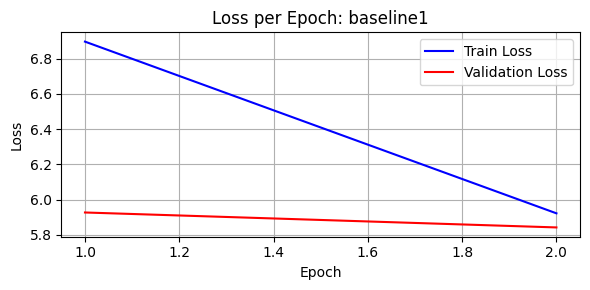

In [ ]:
# 저장된 모델과 학습 이력 불러오기
checkpoint = torch.load(save_model_path, map_location=DEVICE)
checkpoint2 = torch.load(save_history_path, map_location=DEVICE)

# 같은 구조로 모델 재생성 후 state_dict 로드
load_baseline2 = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)
load_baseline2.load_state_dict(checkpoint["model_state_dict"])

# 저장된 이력 중 loss history 가져오기
loss_history_loss_history_baseline1 = checkpoint2["loss_history"]
train_elapsed_time = checkpoint2["train_elapsed_time"]

#  베스트 모델 정보 출력
best_epoch = checkpoint["epoch"] + 1  
best_train_loss = checkpoint["train_loss"]
best_val_loss = checkpoint["val_loss"]
print(f"Best model was saved at Epoch {best_epoch}")
print(f"Train Loss: {best_train_loss:.4f} | Val Loss: {best_val_loss:.4f}")
print(f"Total training time : {train_elapsed_time:.2f} s")

# 그래프 그리기
plot_loss_epoch(model_type, loss_history_loss_history_baseline1)


In [120]:
# 이제 Test 가능
Test(load_baseline1, test_loader, criterion, recipe_vocab)



















Evaluating Metrics: 100%|██████████| 17/17 [00:24<00:00,  1.43s/it]


Test Loss      : 5.9729
BLEU-4 Score   : 0.0255
METEOR Score   : 0.0350
BERTScore (F1) : 0.7084


(5.972874132380455,
 0.025512064079464315,
 0.03496331046761893,
 0.708403468132019)

# Baseline2

model_type = "baseline2"
config = experiment_configs[model_type]

model, encoder, decoder, loss_history, save_model_path, save_history_path = run_train(model_type, config)


In [ ]:
# 저장된 모델과 학습 이력 불러오기
checkpoint = torch.load(save_model_path, map_location=DEVICE)
checkpoint2 = torch.load(save_history_path, map_location=DEVICE)

# 같은 구조로 모델 재생성 후 state_dict 로드
load_baseline2 = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)
load_baseline2.load_state_dict(checkpoint["model_state_dict"])

# 저장된 이력 중 loss history 가져오기
loss_history_loss_history_baseline1 = checkpoint2["loss_history"]
train_elapsed_time = checkpoint2["train_elapsed_time"]

#  베스트 모델 정보 출력
best_epoch = checkpoint["epoch"] + 1  
best_train_loss = checkpoint["train_loss"]
best_val_loss = checkpoint["val_loss"]
print(f"Best model was saved at Epoch {best_epoch}")
print(f"Train Loss: {best_train_loss:.4f} | Val Loss: {best_val_loss:.4f}")
print(f"Total training time : {train_elapsed_time:.2f} s")

# 그래프 그리기
plot_loss_epoch(model_type, loss_history_loss_history_baseline1)


In [ ]:
# 이제 Test 가능
Test(load_baseline2, test_loader, criterion, recipe_vocab)

# Plot for all model

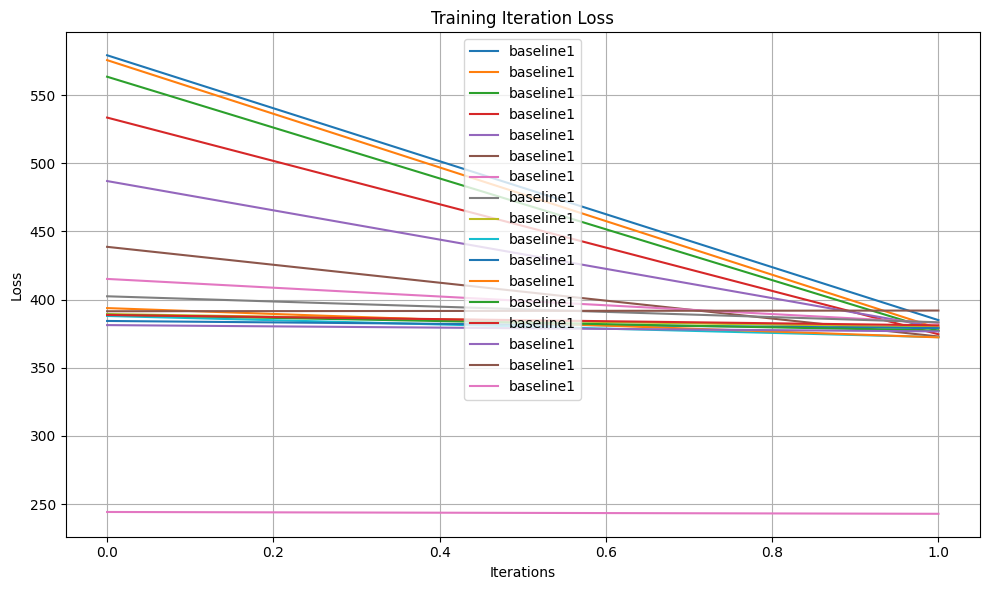

In [74]:
plot_loss_iter(
    baseline1=loss_history_loss_history_baseline1
)


# Generator

In [78]:
def generate_recipes(ingredient_list, ingredient_vocab, recipe_vocab, max_len=30, is_raw_string=False, **models):

    # Tokenizer 적용 여부
    if is_raw_string:
        tokens = tokenizer_ingredient(str(ingredient_list))
    else:
        tokens = ingredient_list

    # index로 변환
    tokens_ids = [ ingredient_vocab[token] if token in ingredient_vocab else ingredient_vocab['<unk>'] for token in tokens]
    src_tensor = torch.tensor(tokens_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)

    print("Ingredient :",', '.join(tokens))
    for name, model in models.items():
        model.eval()
        with torch.no_grad():
            generated = model(src_tensor, target=None, teacher_forcing_ratio=0.0, max_len=max_len)
            pred_ids = generated[0].tolist()

            # <eos> 기준으로 자르기
            if recipe_vocab['<eos>'] in pred_ids:
                pred_ids = pred_ids[:pred_ids.index(recipe_vocab['<eos>'])]

            pred_tokens = [recipe_vocab.get_itos()[idx] for idx in pred_ids]
            print(f"{name}: {' '.join(pred_tokens[:30])}")
    print("-" * 100)

    

In [79]:
models = {
    "Baseline1": load_baseline1
    # "Baseline2": load_baseline2
}

# # Sample 1: 전처리된 리스트
sample1_raw = "sugar, lemon juice,  water,  orange juice, strawberries, icecream"
sample1 = sample1_raw.split(", ")
generate_recipes(sample1, ingredient_vocab, recipe_vocab, is_raw_string=False, **models)

# Sample2 : 
sample2_raw ="8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c  lemon juice, 48 oz canned cherries, 8 inch graham cracker,  pie crusts"
sample2 = sample2_raw.split(", ")
sample2 = ["1-1/2 lb hamburger", "1 lg can pork and beans", "1-1/2 tsp chili powder", "2 or 3 dashes worcestershire sauce", "16 oz ketchup", "1 can stewed tomatoes", "1 med onion chopped (optional)"]
generate_recipes(sample2, ingredient_vocab, recipe_vocab, is_raw_string=True, **models)

Ingredient : sugar, lemon juice,  water,  orange juice, strawberries, icecream
Baseline1: mix and and and and and and and and and and and and and and and and and and and and and and and and and and and and and
----------------------------------------------------------------------------------------------------
Ingredient : hamburger, lg, pork, beans, chili, powder, dashes, worcestershire, sauce, ketchup, stewed, tomatoes, med, onion, chopped, optional
Baseline1: mix and and and and and and and and and and and and and and and and and and and and and and and and and and and and and
----------------------------------------------------------------------------------------------------


In [ ]:
##### 예전꺼(결과있음!!!) #####
def compute_bleu(model, dataloader, recipe_vocab, max_len=50):
    """
    Seq2Seq 모델의 BLEU 점수를 계산 (1~4-gram 기준)

    Args:
        model: 학습된 Seq2Seq 모델
        dataloader: 검증 또는 테스트 DataLoader
        recipe_vocab: recipe vocab 객체 (인덱스 → 단어 변환용)
        max_len: 생성할 최대 문장 길이

    Returns:
        bleu_score (float): 0~100 사이의 BLEU 점수
    """
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for src_batch, trg_batch in tqdm(dataloader, desc="Evaluating BLEU"):
            src_batch = src_batch.to(DEVICE)
            trg_batch = trg_batch.to(DEVICE)

            # 생성된 예측 시퀀스: [batch_size, max_len]
            generated = model(src_batch, target=None, teacher_forcing_ratio=0.0, max_len=max_len)

            for i in range(src_batch.size(0)):
                pred_tokens = generated[i].tolist()
                trg_tokens = trg_batch[i].tolist()

                # <eos> 토큰이 나오면 거기서 자름
                if recipe_vocab['<eos>'] in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(recipe_vocab['<eos>'])]
                if recipe_vocab['<eos>'] in trg_tokens:
                    trg_tokens = trg_tokens[:trg_tokens.index(recipe_vocab['<eos>'])]

                preds.append(pred_tokens)
                targets.append([trg_tokens])  # corpus_bleu는 list of list 필요

    bleu = corpus_bleu(targets, preds) * 100
    print(f"\nBLEU Score: {bleu:.2f}")
    return bleu


def loss_epoch(model, dataloader, criterion, optimizer=None, teacher_forcing_ratio=0.5):
    """
    학습 또는 평가 루프에서 1 epoch 동안 loss만 계산하는 함수.

    Args:
        model: Seq2Seq 모델
        dataloader: DataLoader
        criterion: 손실 함수 (CrossEntropyLoss)
        optimizer: 옵티마이저 (None이면 eval 모드로 동작)
        teacher_forcing_ratio: 학습 중 Teacher Forcing 비율

    Returns:
        epoch_loss: 전체 데이터셋에 대한 평균 loss
    """
    model.train() if optimizer else model.eval()
    rloss = 0

    for src_batch, trg_batch in tqdm(dataloader, leave=False):
        src_batch = src_batch.to(DEVICE)
        trg_batch = trg_batch.to(DEVICE)

        output = model(src_batch, trg_batch, teacher_forcing_ratio=teacher_forcing_ratio)
        output_dim = output.shape[-1]

        # CrossEntropyLoss 계산을 위한 reshape
        output = output[:, 1:, :].reshape(-1, output_dim)
        trg = trg_batch[:, 1:].reshape(-1)

        loss = criterion(output, trg)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

        rloss += loss.item() * src_batch.shape[0]

    return rloss / len(dataloader.dataset)

def Train(model, train_loader, val_loader, criterion, optimizer,
          EPOCHS, BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path,
          ):
    """
    이어서 학습할 수 있게 start_epoch와 best_val_loss를 인자로 받음
    """

    loss_history = {"train": [], "val": []}
    best_val_loss = float('inf')
    train_start_time = time.time()
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        ep_start_time = time.time()

        # Training
        train_loss = loss_epoch(model, train_loader, criterion, optimizer, teacher_forcing_ratio=0.5)
        loss_history["train"].append(train_loss)

        # Validation
        val_loss = loss_epoch(model, val_loader, criterion, optimizer=None, teacher_forcing_ratio=0.0)
        loss_history["val"].append(val_loss)

        ep_elapsed_time = time.time() - ep_start_time

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
                "train_loss": train_loss,  # train_loss 저장
            }, save_model_path)
            print("Best model saved!")

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {ep_elapsed_time:.2f}s")
    train_elapsed_time = time.time() - train_start_time
    # Save training history
    torch.save({
        "loss_history": loss_history,
        "EPOCHS": EPOCHS,
        "BATCH_SIZE": BATCH_SIZE,
        "TRAIN_RATIO": TRAIN_RATIO
    }, save_history_path)

    print(f"\nTraining Completed! History saved!| Elapsed Time : {train_elapsed_time}")
    return loss_history


def Test(model, test_loader, criterion, recipe_vocab):
    """
    테스트 데이터셋에서 손실과 BLEU 점수를 계산하는 함수.

    Args:
        model: 학습된 Seq2Seq 모델
        test_loader: 테스트 DataLoader
        criterion: 손실 함수
        recipe_vocab: vocab 객체 (BLEU 계산용)

    Returns:
        test_loss (float), bleu_score (float)
    """
    print("\n Testing on test set...")
    model.eval()

    with torch.no_grad():
        test_loss = loss_epoch(model, test_loader, criterion, optimizer=None, teacher_forcing_ratio=0.0)

    bleu_score = compute_bleu(model, test_loader, recipe_vocab)
    print(f"Test Loss: {test_loss:.4f} | BLEU Score: {bleu_score:.2f}")

    return test_loss, bleu_score




New model training!

Epoch 1/10


  0%|          | 0/2546 [00:00<?, ?it/s]/home/psarda/repos/NLP/.venv/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Best model saved!
Train Loss: 4.3775 | Val Loss: 4.9679 | Time: 3727.94s

Epoch 2/10


Best model saved!
Train Loss: 3.9285 | Val Loss: 4.9464 | Time: 3716.95s

Epoch 3/10


Best model saved!
Train Loss: 3.8209 | Val Loss: 4.8882 | Time: 3724.51s

Epoch 4/10


Train Loss: 3.7594 | Val Loss: 4.8932 | Time: 3715.59s

Epoch 5/10


Train Loss: 3.7219 | Val Loss: 4.9373 | Time: 3987.15s

Epoch 6/10


Train Loss: 3.6916 | Val Loss: 4.8978 | Time: 3766.76s

Epoch 7/10


Train Loss: 3.6670 | Val Loss: 4.9374 | Time: 3943.18s

Epoch 8/10


Train Loss: 3.6451 | Val Loss: 4.8948 | Time: 4250.35s

Epoch 9/10


Train Loss: 3.6278 | Val Loss: 4.9209 | Time: 4195.73s

Epoch 10/10


Train Loss: 3.6148 | Val Loss: 4.9444 | Time: 4038.07s

Training Completed! History saved!| Elapsed Time : 39066.561606884


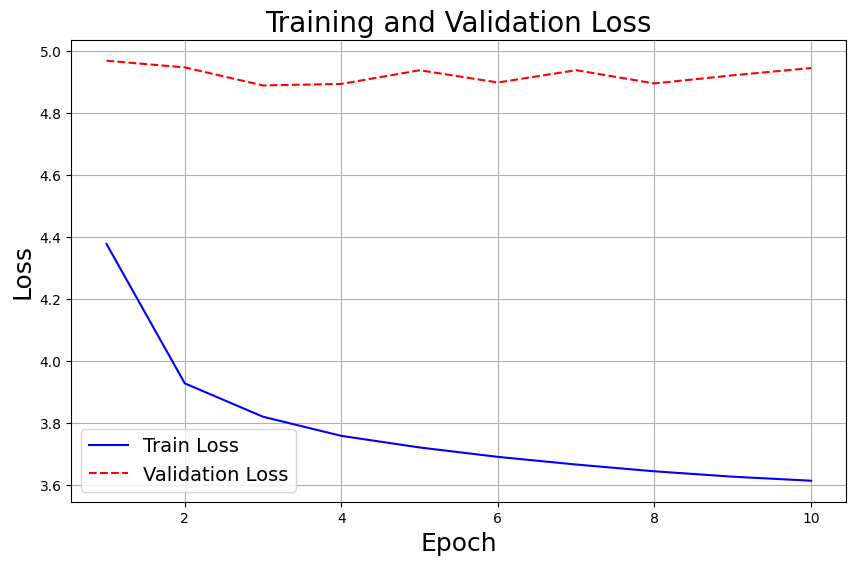

In [ ]:
##### 예전꺼(결과있음!!!) #####

# 모델 생성
encoder = Encoder_GRU(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
decoder = Decoder_GRU(OUTPUT_DIM, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)

if new_model_train:
    print("New model training!")
    optimizer = optim.Adam(model.parameters(), lr=LR)

    loss_history = Train(
        model=model,
        train_loader=train_loader,
        val_loader=dev_loader,
        criterion=criterion,
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        BATCH_SIZE=BATCH_SIZE,
        TRAIN_RATIO=TRAIN_RATIO,
        save_model_path=save_model_path,
        save_history_path=save_history_path,
    )

    # 플롯 그리기
    plt.figure(figsize=(10,6))
    plt.plot(range(1, EPOCHS+1), loss_history["train"], label="Train Loss", color="blue")
    plt.plot(range(1, EPOCHS+1), loss_history["val"], label="Validation Loss", color="red", linestyle='--')
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Loss", fontsize=18)
    plt.title("Training and Validation Loss", fontsize=20)
    plt.legend(fontsize=14)
    plt.grid()
    plt.show()
